# Bank marketing campaign classifier:
This project is being conducted as part of my virtual internship with PwC, with the primary objective of enhancing a bank's phone marketing algorithm. The project involves developing a classification model for the bank to predict whether a specific individual will subscribe to a term deposit. Additionally, the project seeks to analyze and identify the key features or variables that have the greatest influence on the classification outcome. Please note that the main goal of this project is mainly to find the most contributing features to the classification outcome and not achieve a high performance.

The data is related with direct marketing campaigns of a Portuguese banking institution and can be accessed here: https://archive.ics.uci.edu/dataset/222/bank+marketing.

In [ ]:
#pip install --upgrade pip 
!pip install imblearn
!pip install lime

In [1]:
# Data manipulation & visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import warnings

## Feature transformation & selection libraries
warnings.filterwarnings('ignore')
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# Build the model
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.svm import SVC

# Model evaluation
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as conf_matrix
from sklearn.inspection import permutation_importance
import lime
from lime import lime_tabular


In [2]:
bank = pd.read_csv('bank-additional-full.csv', sep = ';')

### 1.1 Information about the features of the dataset:
We will only provide explanations for certain variables that may be difficult to understand:

Bank client data: 
- Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
- Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
- Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

Last contact of the marketing campaign:
- Contact: Type of communication used (categorical: 'cellular', 'telephone') 
- Month: The month of the last contact in the year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') 
- Day_of_week: The day of the week of the last contact (categorical: 'mon', 'tue', 'wed', 'thu', 'fri'). 
- Duration: The duration of the last contact in seconds (numeric)
- Campaign: The number of contacts made during this campaign for this client, including the last contact (numeric)
- Pdays: The number of days that have passed since the client was last contacted in a previous campaign (numeric; 999 indicates that the client was not previously contacted)
- Previous: The number of contacts made before this campaign for this client (numeric)
- Poutcome: The outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success').


In [7]:
#Some variables are numerical while others are categorical.
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [21]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [3]:
#Duration (of the last contact) variable is irrelevant because it highly affects the output target. If the duration is equal to 0,
#the y variable ( has the client subscribed a term deposit?) will be "no". So, the duration will be dropped.

df = bank.copy()
bank = df.drop(["duration"], axis= 1)

### 1.2 Data cleaning:
- Dealing with missing values and duplicates.
- Lets perform an outlier analysis by plotting a boxplot, an histogram and a probability plot for each of the continuous variables.

In [5]:
#handle the missing values
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [54]:
#there are 1784 duplicates
bank.duplicated().sum()

1784

In [4]:
#remove duplicates
bank.drop_duplicates(inplace=True)

In [6]:
#reset indices after dropping rows
bank = bank.reset_index(drop= True)

In [6]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


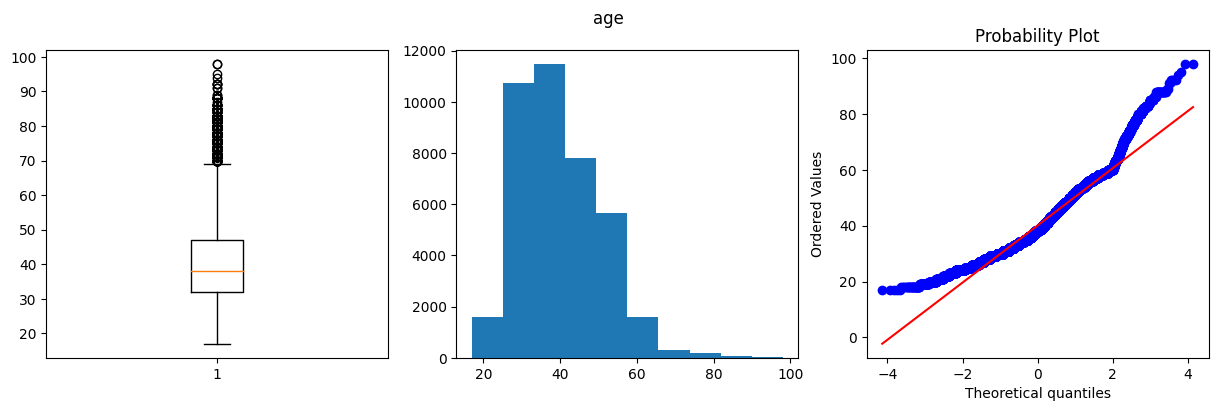

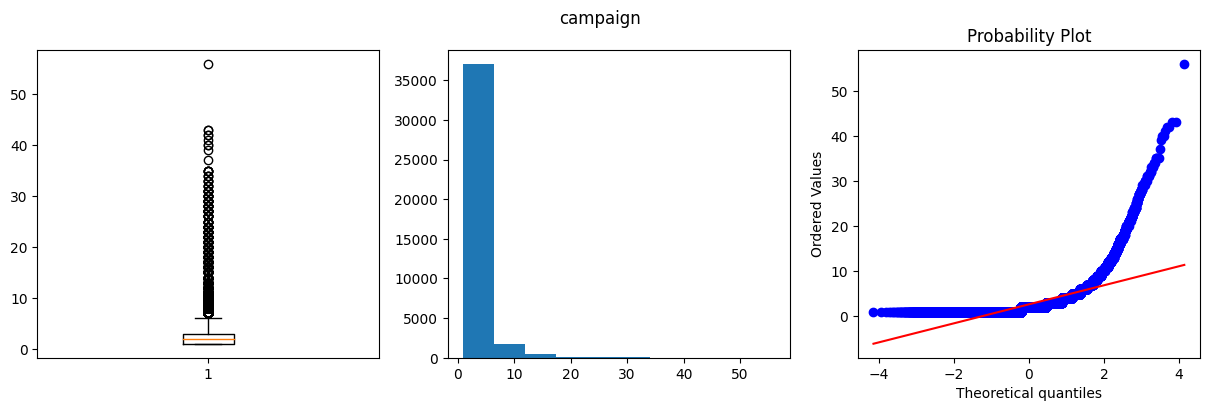

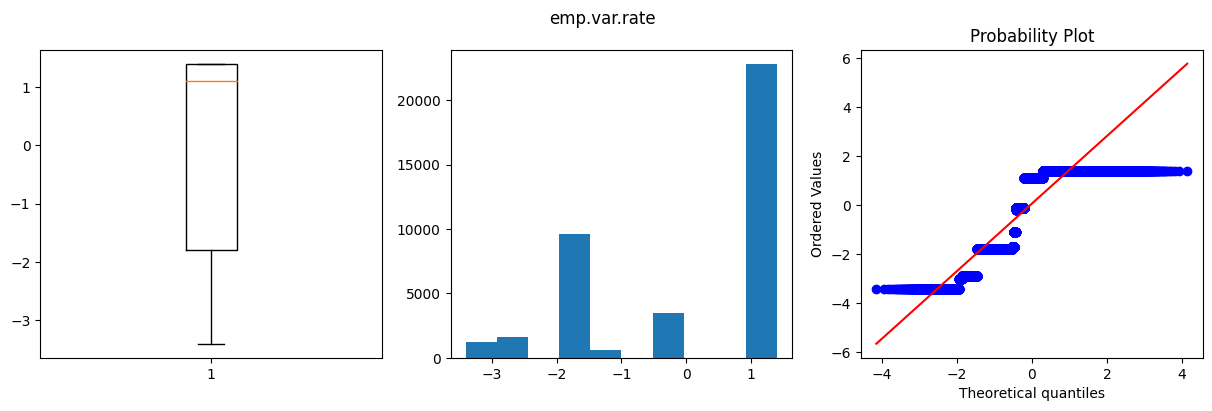

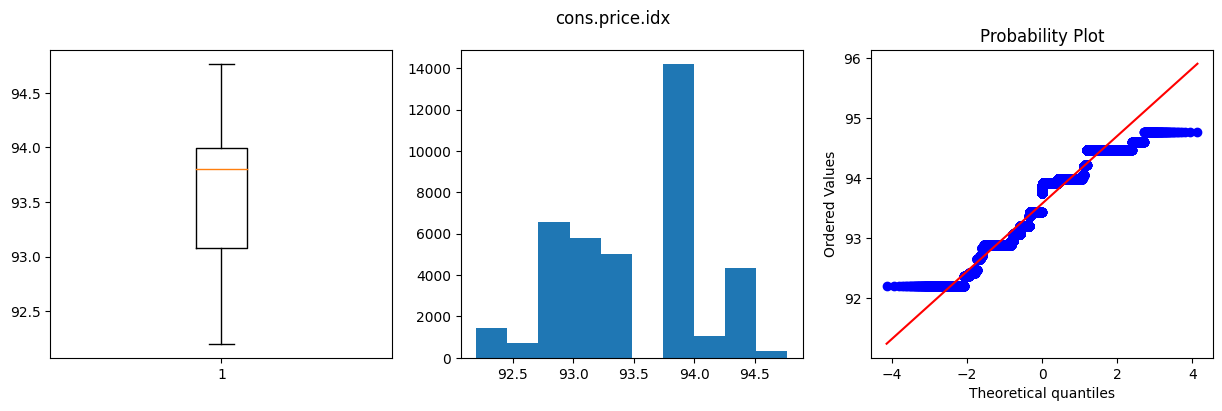

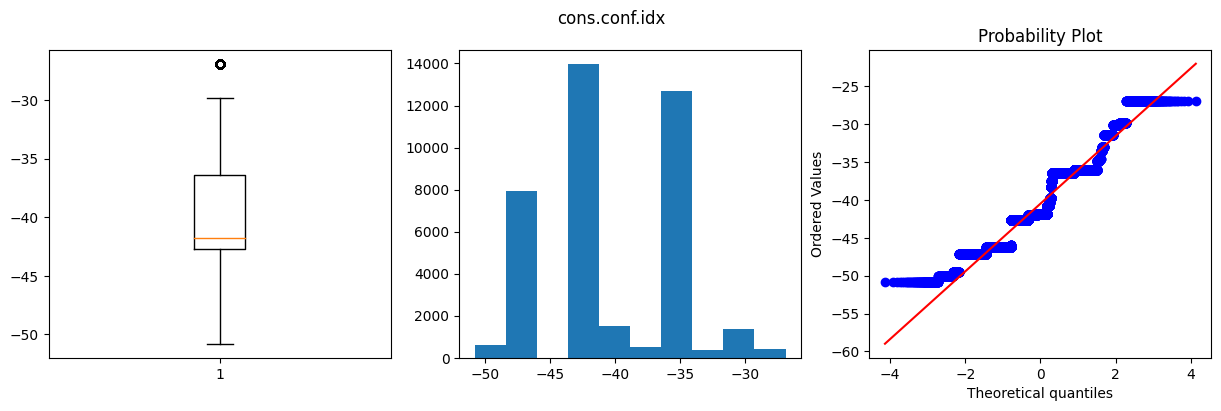

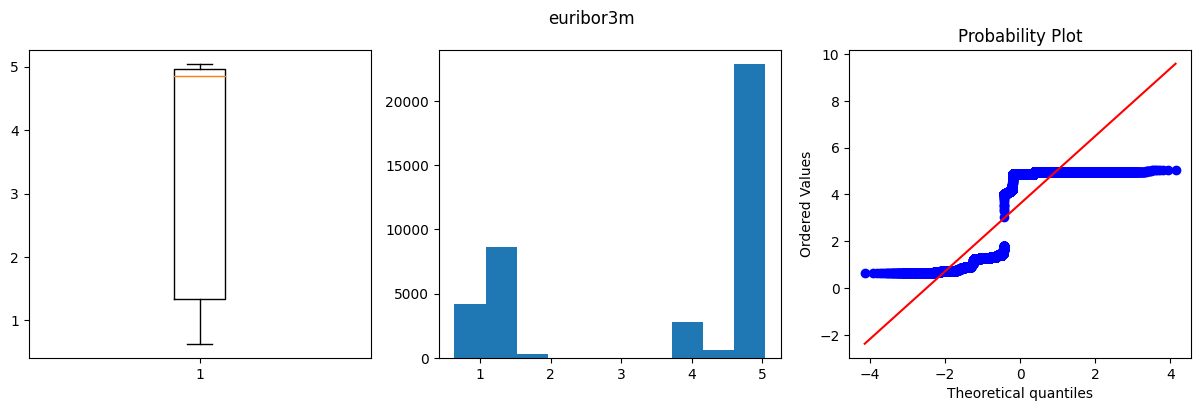

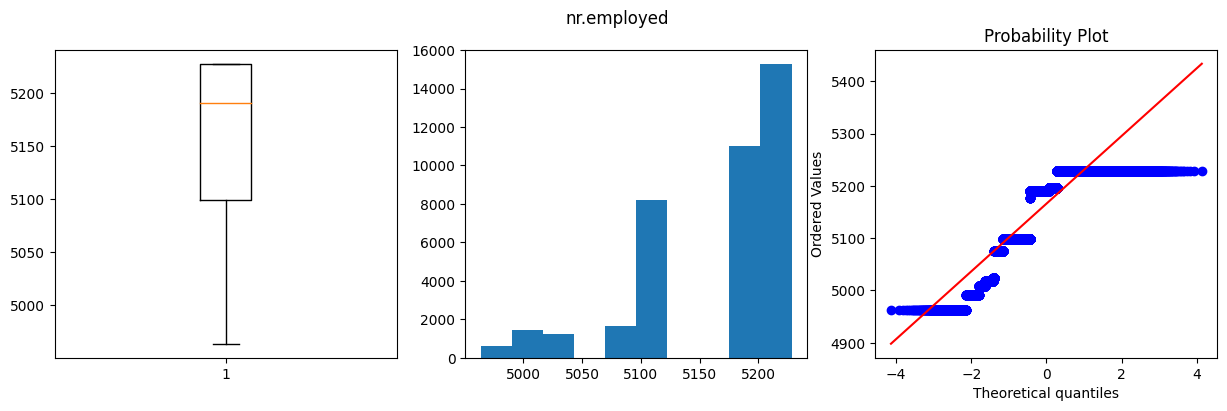

In [13]:
cols = ["age", "campaign", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

for col in cols: 
    fig, axes = plt.subplots(nrows= 1, ncols= 3, figsize= (15,4))
    fig.suptitle(col)
    axes[0].boxplot(bank[col])
    axes[1].hist(bank[col])
    stats.probplot(bank[col], dist='norm', plot= axes[2])
    plt.show
    

In [7]:
#The "campaign" and the 'cons.conf.idx' variables are the only variables in which outliers seem to be problematic.
#let's remove them.

col = 'campaign'
bank = bank[(bank[col]) < 50]
bank = bank.reset_index(drop= True)

In [8]:
col = 'cons.conf.idx'
bank = bank[(bank[col] < -28)]
bank = bank.reset_index(drop= True)

### 1.3 Categorical feature encoding:
- categorigal variables need to be encoded to be represented as numerical variables. In this way, they can be understood from the classification model.

In [9]:
#find which are the categorical variables

cat_labels = bank.select_dtypes(include= object)
cat_labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38967 entries, 0 to 38966
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job          38967 non-null  object
 1   marital      38967 non-null  object
 2   education    38967 non-null  object
 3   default      38967 non-null  object
 4   housing      38967 non-null  object
 5   loan         38967 non-null  object
 6   contact      38967 non-null  object
 7   month        38967 non-null  object
 8   day_of_week  38967 non-null  object
 9   poutcome     38967 non-null  object
 10  y            38967 non-null  object
dtypes: object(11)
memory usage: 3.3+ MB


In [11]:
#check how many categories each variable has
cat_labels.nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

In [10]:
# the variable "contact' and the target variable 'y' have two possible categories. So, a simple label encoding will be used.
#The following piece of code first converts a column to category and then encode the variables
bank["contact"] = bank["contact"].astype('category').cat.codes
bank["y"] = bank["y"].astype('category').cat.codes

In [ ]:
#for the rest of the variables, we will perform one-hot encoding

In [11]:
encoder = OneHotEncoder(sparse = False)

columns = ['job','marital','education','default','housing','loan','month','day_of_week','poutcome']
df_encoded = pd.DataFrame (encoder.fit_transform(bank[columns]))
df_encoded.columns = encoder.get_feature_names_out(columns)
bank.drop(columns ,axis=1, inplace=True)
bank= pd.concat([bank, df_encoded ], axis=1)

### 1.4 Data transformation:
- deal with the skewed data.
- apply transformations.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'nr.employed'}>]], dtype=object)

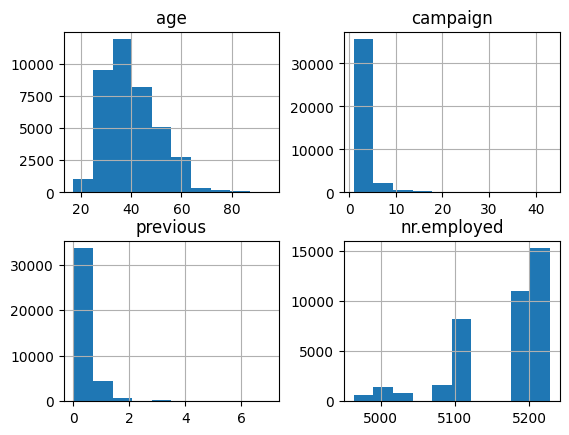

In [20]:
#by plotting the distributions of these variables, it looks like the "age", "campaign" and "previous" variables are right skewed and
#the nr.employed is left skewed
bank.hist(column=["age","campaign","previous", "nr.employed"])      

In [12]:
#apply logarithmic transformation to the right skewed data to conform to normality. In this method, we will use
#the log of each value. So, we will use their exponents instead of their actual values.
#In this way, it makes the X scale exponentially grow in value.

log_transformer = FunctionTransformer(np.log1p, validate= True)
cols = ["age","campaign","previous"]
right_skewed= log_transformer.transform(bank[cols])

bank["age"] = right_skewed[:, 0]
bank["campaign"] = right_skewed[:, 1]
bank["previous"] = right_skewed[:, 2]

In [13]:
#apply square root transformation to the left skewed data. We will use square of each and every value in the data.

exp_transformer = FunctionTransformer(lambda x: x**2, validate= True)
FunctionTransformer(np.exp, validate= True)
col = ["nr.employed"]
left_skewed = exp_transformer.transform(bank[col])

bank["nr.employed"] = left_skewed[:, 0]

### 1.5 Data discretization:
- converts continuous data into discrete collection of intervals.

In [14]:
age = pd.DataFrame(bank, columns= ["age"])
discretizer = KBinsDiscretizer(n_bins= 10, encode= 'ordinal', strategy= 'kmeans')
discretizer.fit(age)
_discretize = discretizer.transform(age)
x = pd.DataFrame(_discretize, columns= ["age"])
bank["age"] = x["age"]

In [15]:
bank["age"].head()

0    7.0
1    7.0
2    4.0
3    4.0
4    7.0
Name: age, dtype: float64

### 1.6 Feature scaling: 
- normalizing the range of features to be on the same scale. 
- assure to keep only the continuous columns and remove the age column which its discretized.

In [15]:
bank_2 = bank
#access the continuous columns
cols_cont = bank.iloc[:, 0:10].columns

#access the categorical columns
cols_categorical = bank.iloc[:, 10:].columns

#keep the continuous variables except the age which is discretized and its not needed to be standardized.
without_age = cols_cont.difference(["age"])

In [16]:
scaler = StandardScaler()

scaled_cols = pd.DataFrame(bank, columns= without_age)
scaler.fit(scaled_cols)

bank = pd.DataFrame(scaler.transform(scaled_cols), columns= without_age).join(bank[cols_categorical]).join(bank_2['age'])

In [17]:
#move 'age' column from last to first position
cols_list =  bank.columns.tolist()
cols_list = [cols_list[-1]] + cols_list[:-1]
bank = bank[cols_list] 

### 1.7 Splitting the dataset & deal with class-imbalanced data:
- perform SMOTE, one of the most commonly used oversampling techniques to tackle imbalanced datasets by generating synthetic samples for the minority class.
- split to train and test data

<Axes: xlabel='y', ylabel='count'>

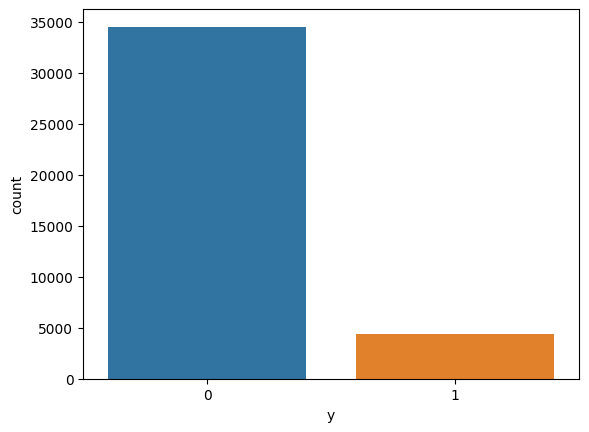

In [18]:
#by simply, creating a barplot, we notice the target variable is imbalanced.

sns.barplot(x= bank['y'].value_counts().index, y= bank['y'].value_counts())

In [19]:
#the "y" column is the target variable and the rest features are the independendent variables
Y = 'y'
X = bank.loc[:, bank.columns != Y].columns

In [20]:
#divide the dataset with a split ration 70:30. 70% of the dataset corresponds to the training dataset and
#30% goes into the testing set
X_train, X_test, y_train, y_test = train_test_split(bank[X], bank[[Y]],test_size=0.3, random_state=100)

smt = SMOTE(sampling_strategy= "minority", random_state=101)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [21]:
#print the shape of the independent variables and the target variable
print("Independent variables:", X_train.shape, X_test.shape)
print("Target variable:", y_train.shape, y_test.shape)


Independent variables: (48346, 61) (11691, 61)
Target variable: (48346, 1) (11691, 1)


<Axes: xlabel='y', ylabel='count'>

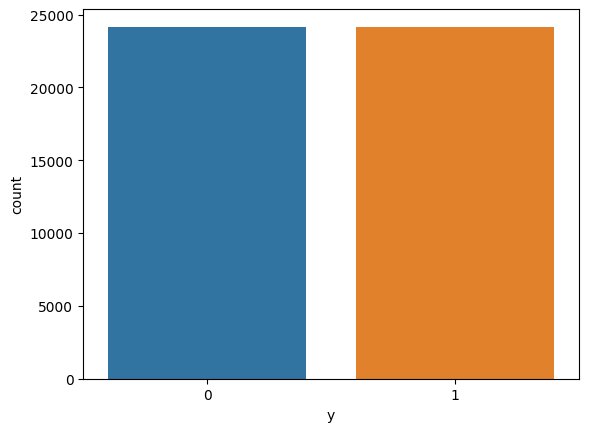

In [22]:
sns.barplot(x= y_train['y'].value_counts().index, y= y_train['y'].value_counts())

### 1.8 Feature selection
a) Correlation analysis:
- based on the below heatmap: 'cons.price.idx', 'emp.var.rate', 'euribor3m' and "nr.employed" are dependendent to each other because their correlation coefficients are high.
- no variable has strong correlation with the target variable.
- "nr.employed" and "euribor3m" variables have weak correlation with the target variable.
- conclusion: I will keep nr.employed as a variable that might be more representative of the following variables. I will drop 'cons.price.idx', 'emp.var.rate', 'euribor3m' since they are higly correlated with each other.

b) Univariate feature selection: 
- After performing encoding on the categorical variables, there is an significant increase in dimensionality. The number of features is increased from 20 to 62. Also, not all the features are needed to predict the target variable. To deal with the above issues, we will find the most important features by employing feature selection. A very computationall efficient method is the univariate feature selection. The idea behind this method is to evaluate each individual feature’s relationship with the target variable and select the ones that have the defined criteria. The measure can be correlation or another statistical significance. For this reason, F-score will be chosen as measure. F is calculated as the ratio of the variance between the groups to the variance within the groups. A large F-value means the between-group variation is larger than your within-group variation. So, it reveals  how well a feature can separate different classes or groups in a dataset. 


<Axes: >

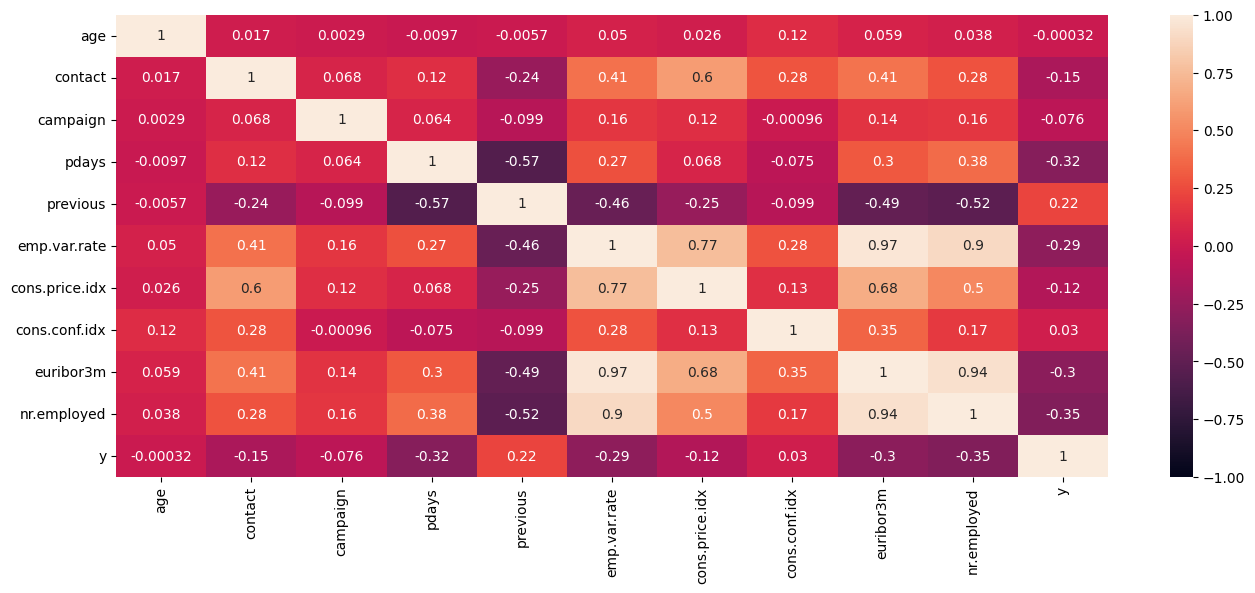

In [24]:
#access the continuous variables created before
cont_features = bank[cols_cont]
cont_features_target = cont_features.join(bank["y"])

correlations = cont_features_target.corr()

plt.figure(figsize= (16, 6))
sns.heatmap(correlations, vmin= -1, vmax= 1,  annot=True)

In [23]:
columns_to_drop = ['emp.var.rate', 'cons.price.idx', 'euribor3m']

X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [24]:
top_features = SelectKBest(f_classif, k=10)
top_features.fit(X_train, y_train)

SelectKBest()

In [34]:
print('Number of input features:', top_features.n_features_in_)
print('Input features Names  :', top_features.feature_names_in_)
print('Input features F-statistic scores :', top_features.scores_)
print('Input features pvalues:', top_features.pvalues_)
print('Output features Names :', top_features.get_feature_names_out())

Number of input features: 58
Input features Names  : ['age' 'campaign' 'cons.conf.idx' 'contact' 'nr.employed' 'pdays'
 'previous' 'job_admin.' 'job_blue-collar' 'job_entrepreneur'
 'job_housemaid' 'job_management' 'job_retired' 'job_self-employed'
 'job_services' 'job_student' 'job_technician' 'job_unemployed'
 'job_unknown' 'marital_divorced' 'marital_married' 'marital_single'
 'marital_unknown' 'education_basic.4y' 'education_basic.6y'
 'education_basic.9y' 'education_high.school' 'education_illiterate'
 'education_professional.course' 'education_university.degree'
 'education_unknown' 'default_no' 'default_unknown' 'default_yes'
 'housing_no' 'housing_unknown' 'housing_yes' 'loan_no' 'loan_unknown'
 'loan_yes' 'month_apr' 'month_aug' 'month_dec' 'month_jul' 'month_jun'
 'month_mar' 'month_may' 'month_nov' 'month_oct' 'month_sep'
 'day_of_week_fri' 'day_of_week_mon' 'day_of_week_thu' 'day_of_week_tue'
 'day_of_week_wed' 'poutcome_failure' 'poutcome_nonexistent'
 'poutcome_success']


### 2. Train the model:

Support Vector Machines(SVM) algorithm was selected to build the model.

Hyperparameters in SVM algorithm:
 
- gamma = smaller number, smoother decision boundary --> underfitting. Larger number, a more complex decision boundary --> overfitting
        
        
- C = larger the number, narrower the hyperplane margin --> prone to overfitting but less training error rate. Smaller the number larger the hyperplane margin --> prone to underfitting but higher training error rate

In [25]:
clf = svm.SVC(C=200 , kernel= 'rbf', gamma= 0.1,random_state=42, probability= True) 

In [26]:
X_train = pd.DataFrame(top_features.transform(X_train),columns=top_features.get_feature_names_out())
X_test = pd.DataFrame(top_features.transform(X_test),columns=top_features.get_feature_names_out())


In [27]:
clf.fit(X_train, y_train)

SVC(C=200, gamma=0.1, probability=True, random_state=42)

In [29]:
# Predict the response for the dataset 
y_pred = clf.predict(X_test)

### 2.1 Model evaluation

In [30]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8408177230348131


In [40]:
print(classification_report(y_test, y_pred,target_names=['no term deposit ', 'term deposit']))

                  precision    recall  f1-score   support

no term deposit        0.94      0.87      0.91     10373
    term deposit       0.37      0.60      0.46      1318

        accuracy                           0.84     11691
       macro avg       0.66      0.74      0.68     11691
    weighted avg       0.88      0.84      0.86     11691



#### Interpretation: 
Precision (TP / TP + FP)(False Positive Rate) is really low 0.37 for the term deposit, meaning that out of all the instances predicted as
"term deposit" only the 37% of them were correct (the other 63% were no subscribers).

Recall = (TP / TP + FN)(True Positive Rate) is 0.60. Out of all the actual instances of "term deposit", the 60% of them are correct.

In that case, recall is more important measure than precision. It is better for the model to predict correctly a larger percentage of actual "subscribers" than predicting a subscriber as non-subscriber. On the other hand, it is not a big problem to predict as "subscribers" clients
who are not.

Finally, the really low precision for the "term deposit" class can be attributed to the fact that there is an imbalanced dataset for the classes. The "term deposit" class is underpresented in this dataset.

In [41]:
# compute the confusion matrix
cm = conf_matrix(y_test,y_pred)

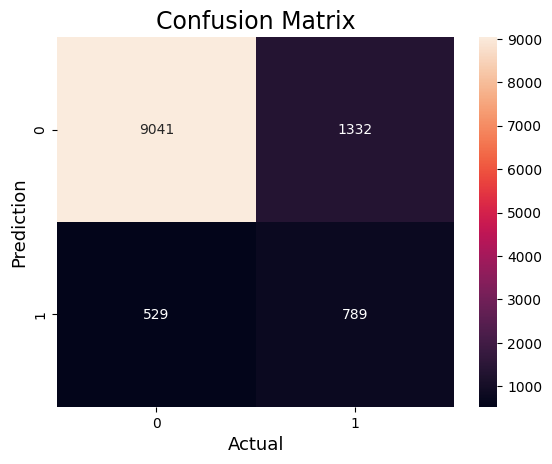

In [42]:
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### 2.2 Feature importance evaluation: 
a) Global level explanations: To find the features that contribute the most to the model's performance importance (https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature) technique was employed. It measures which features have contributed the most to the performance of a model. In a nutshell, this method shuffles a feature column and then it compares the original performance with the performance of the shuffled data. It actually computes the feature importance for each feature as the difference between the baseline performance and the performance on the permuted dataset.

b) Local level explanations: Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. Instead of training a global surrogate model, LIME (https://lime-ml.readthedocs.io/en/latest/) focuses on training local surrogate models to explain individual prediction.


In [32]:
perm_importance = permutation_importance(clf, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

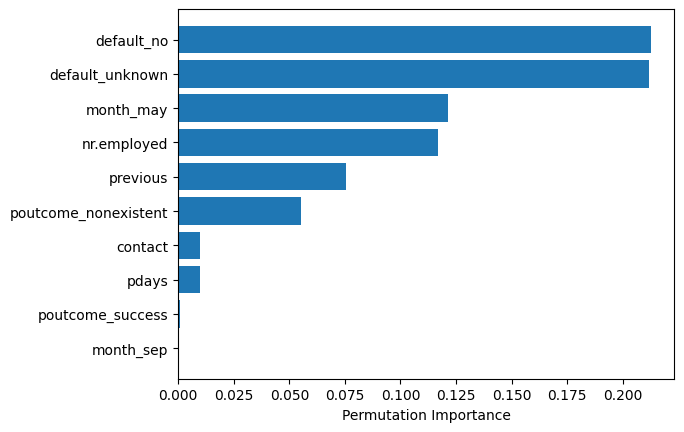

In [33]:
features = np.array(X_train.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#### Global explanations of the model in each feature
The features that contribute the most to the classification model are with high values: 
- the "default_no" and "default_unknown" feature (after encoding): when a bank client does not have or it is unknown if a bank client has a credit in default. 
- the month of May as the last contact of the marketing campaing is an important feature to classify correctly if a client has a term deposit or not.
- the "nr.employed" (number of employees for a specific region) is an important feature as well.
- the "previous" feature that corresponds to the number of contacts performed by the bank before this campaing, seems to be a significant feature for the model's performance.
- Finally, the absence of an outcome of the previous marketing campaign (poutcome_noexistent) acts as a crucial feature to predict target variable.


In [48]:
#Local explanations using LIME.

cols = X_train.columns

explainer = lime_tabular.LimeTabularExplainer(
    training_data= X_train.to_numpy(),
    feature_names= cols,
    class_names= [0,1],
    mode= 'classification'
)

In [74]:
# explanations for #4 observation

#X_test = X_test.to_numpy()  comment this if X_test is already a numpy.ndarray object

exp = explainer.explain_instance(
    data_row = X_test[3],
    predict_fn = clf.predict_proba
)

exp.show_in_notebook(show_table= True, show_all= True)

In [75]:
# explanations for #20 observation

exp = explainer.explain_instance(
    data_row = X_test[19],
    predict_fn = clf.predict_proba
)

exp.show_in_notebook(show_table= True, show_all= True)






#### Local explanations of the model: 
For the bank client located on the 4th row of the dataset, The SVM model predicts with 72% confidence that the client has not subscribed to a term deposit. The features that contribute the most to this decision are 'previous,' 'contact,' and 'default_unknown,' while the 'month of May' has the least impact. On the contrary, poutcome_success, month_sep and nr.employed decreases the chance of the test sample to be predicted as not having a term deposit. 

For the bank client on the 20th row, the model is 72% sure that this client has not subscribed to a term deposit. The important features to this decision are previous and default_unknown. On the other hand, the features contact and nr.employed negatively affect this client to be predicted as someone who has not subscribed to a term deposit.

In conclusion, based on this specific local explanations, Both clients are more likely to be predicted as not having a term deposit. However, it's worth noting that the type of communication (contact feature) has a positive effect on predicting the first client as not having a term deposit, whereas it has a negative impact on predicting the second client as not having a term deposit. We need to determine how and to what extent the type of communication used in the campaign affects the likelihood of those clients choosing to subscribe or not. 